Demo 2

In [2]:
# quick check
import torch, time
x = torch.randn(4096, 4096, device='cuda' if torch.cuda.is_available() else 'cpu')
t0=time.time(); y = x @ x.T; torch.cuda.synchronize() if torch.cuda.is_available() else None
print("OK, matmul shape:", y.shape, "elapsed(s):", round(time.time()-t0,3))

OK, matmul shape: torch.Size([4096, 4096]) elapsed(s): 1.014


MODEL: GPT-5

Task 1

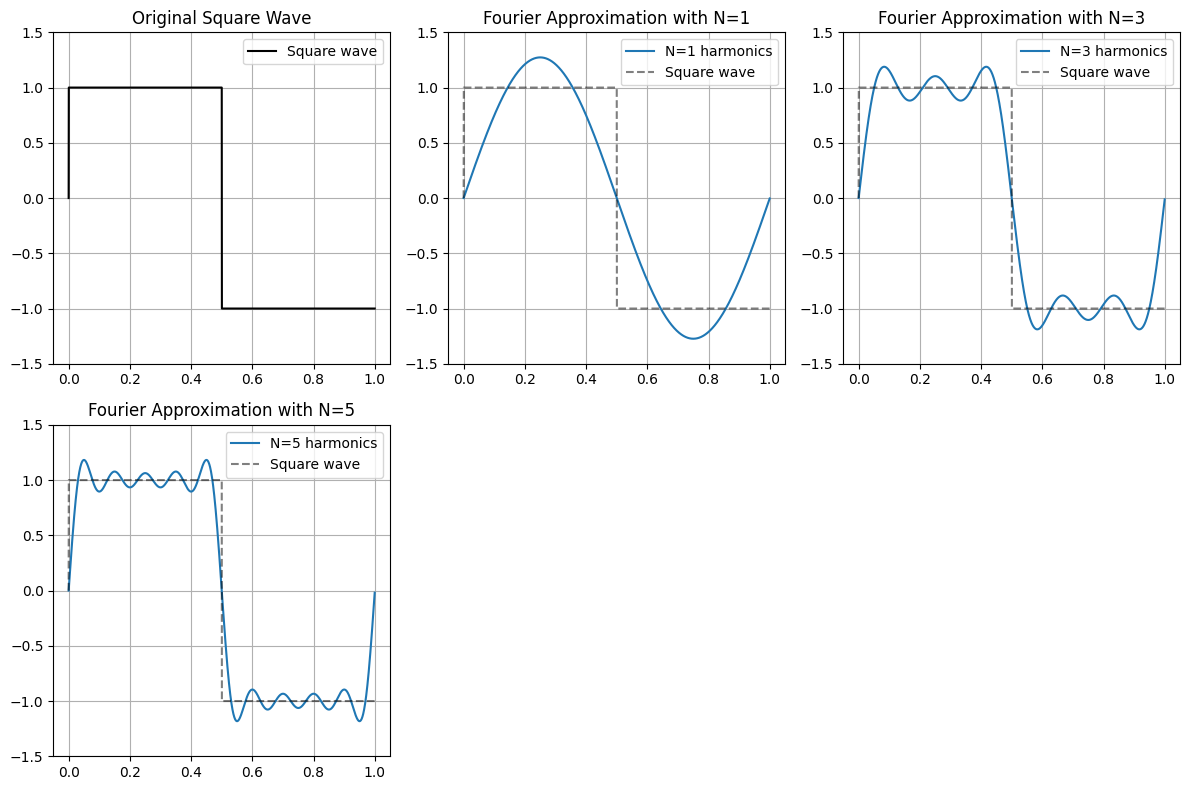

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set parameters for the signal
N = 2048  # Number of sample points
T = 1.0   # Duration of the signal in seconds
f0 = 1    # Fundamental frequency of the square wave in Hz

# List of harmonic numbers used to construct the square wave
harmonics = [1, 3, 5]

# Define the square wave function
def square_wave(t):
    return np.sign(np.sin(2.0 * np.pi * f0 * t))

# Fourier series approximation of the square wave
def square_wave_fourier(t, f0, N):
    result = np.zeros_like(t)
    for k in range(N):
        # The Fourier series of a square wave contains only odd harmonics.
        n = 2 * k + 1
        # Add harmonics to reconstruct the square wave.
        result += np.sin(2 * np.pi * n * f0 * t) / n
    return (4 / np.pi) * result

# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, T, N, endpoint=False)

# Generate the original square wave
square = square_wave(t)

plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


Varying Harmonics Values

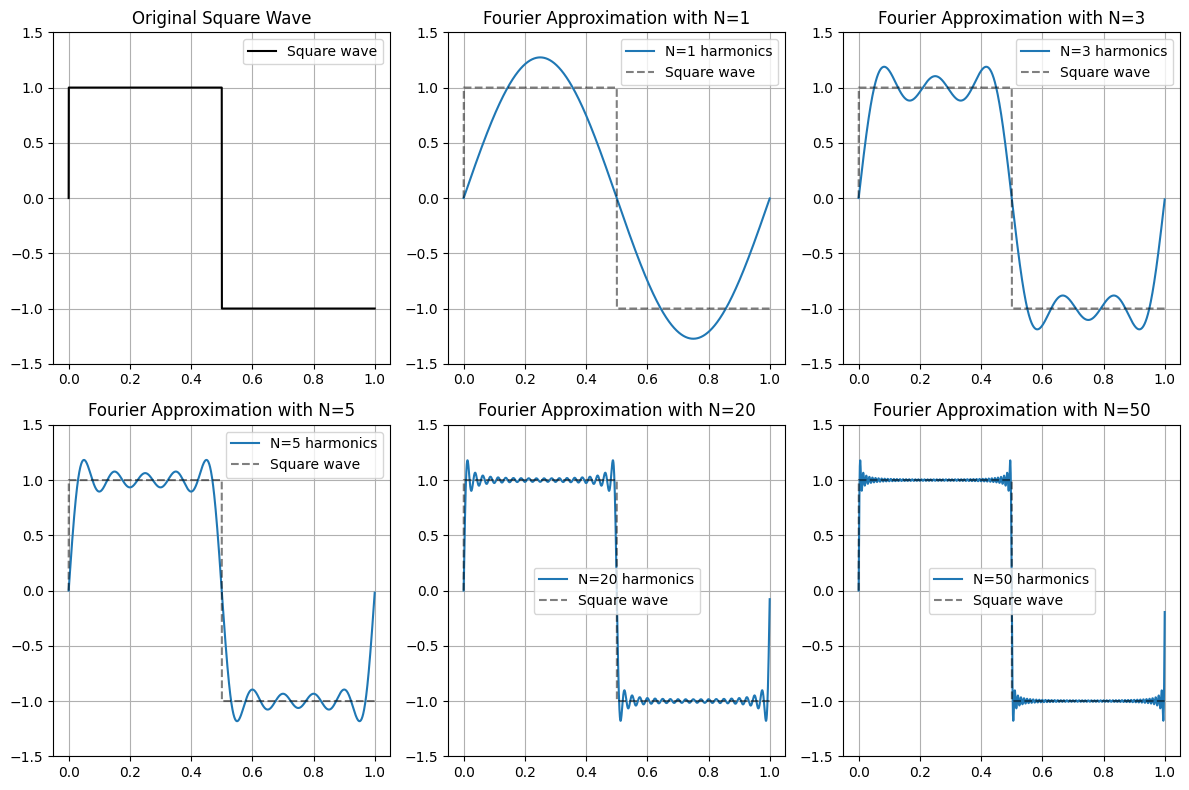

In [2]:
harmonics = [1, 3, 5, 20, 50]

plt.figure(figsize=(12, 8))

# Plot the original square wave
plt.subplot(2, 3, 1)
plt.plot(t, square, 'k', label="Square wave")
plt.title("Original Square Wave")
plt.ylim(-1.5, 1.5)
plt.grid(True)
plt.legend()

# Plot Fourier reconstructions under different number of harmonics
for i, Nh in enumerate(harmonics, start=2):
    plt.subplot(2, 3, i)
    y = square_wave_fourier(t, f0, Nh)
    plt.plot(t, y, label=f"N={Nh} harmonics")
    plt.plot(t, square, 'k--', alpha=0.5, label="Square wave")
    plt.title(f"Fourier Approximation with N={Nh}")
    plt.ylim(-1.5, 1.5)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


## How do these additional components influence the accuracy and sharpness of the square wave?
TODO

--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 6.184538 seconds
NumPy FFT Execution Time: 0.009773 seconds
FFT is approximately 632.79 times faster.

Our DFT implementation is close to NumPy's FFT: True


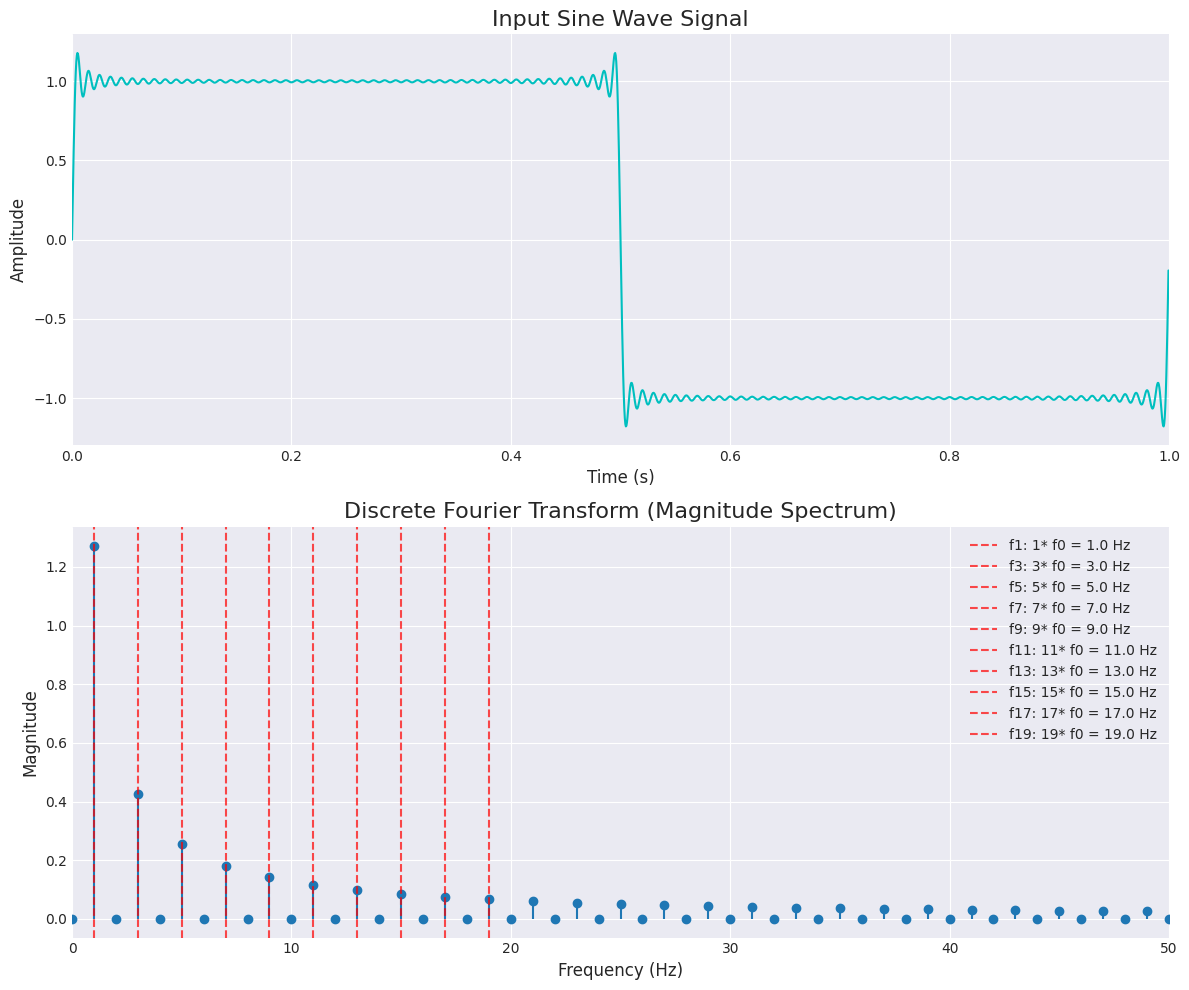

In [3]:
# 2. Apply the DFT and time the execution
def naive_dft(x):
    """
    Compute the Discrete Fourier Transform (DFT) of a 1D signal.
    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).
    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.
    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)
    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            angle = -2j * np.pi * k * n / N
            X[k] += x[n] * np.exp(angle)
    return X

# Construct a square wave using 50 harmonics
signal = square_wave_fourier(t, f0, 50)

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(signal)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(signal)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")
# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")

# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, d=T/N)[:N//2]

# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, signal, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 1.0)  # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
ax2.stem(xf, magnitude, basefmt=" ")
ax2.set_title('Discrete Fourier Transform (Magnitude Spectrum)', fontsize=16)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.set_xlim(0, 50)  # Focus on lower frequencies
ax2.grid(True)

# Add vertical lines for the first ten frequencies
for i in range(20):
    if i < len(xf) and i % 2 == 1:  # Only plot odd harmonics
        ax2.axvline(
            xf[i], color='r', linestyle='--', alpha=0.7,
            label=f'f{i}: {i}* f0 = {xf[i]:.1f} Hz'
        )

# Only show labels for first 3 frequencies to avoid cluttering
ax2.legend()

plt.tight_layout()
plt.show()


AI code below

--- DFT/FFT Performance Comparison ---
Naïve DFT Execution Time: 0.515709 seconds
NumPy FFT Execution Time: 0.000142 seconds
FFT is approximately 3623.19 times faster.

Our DFT implementation is close to NumPy's FFT: True


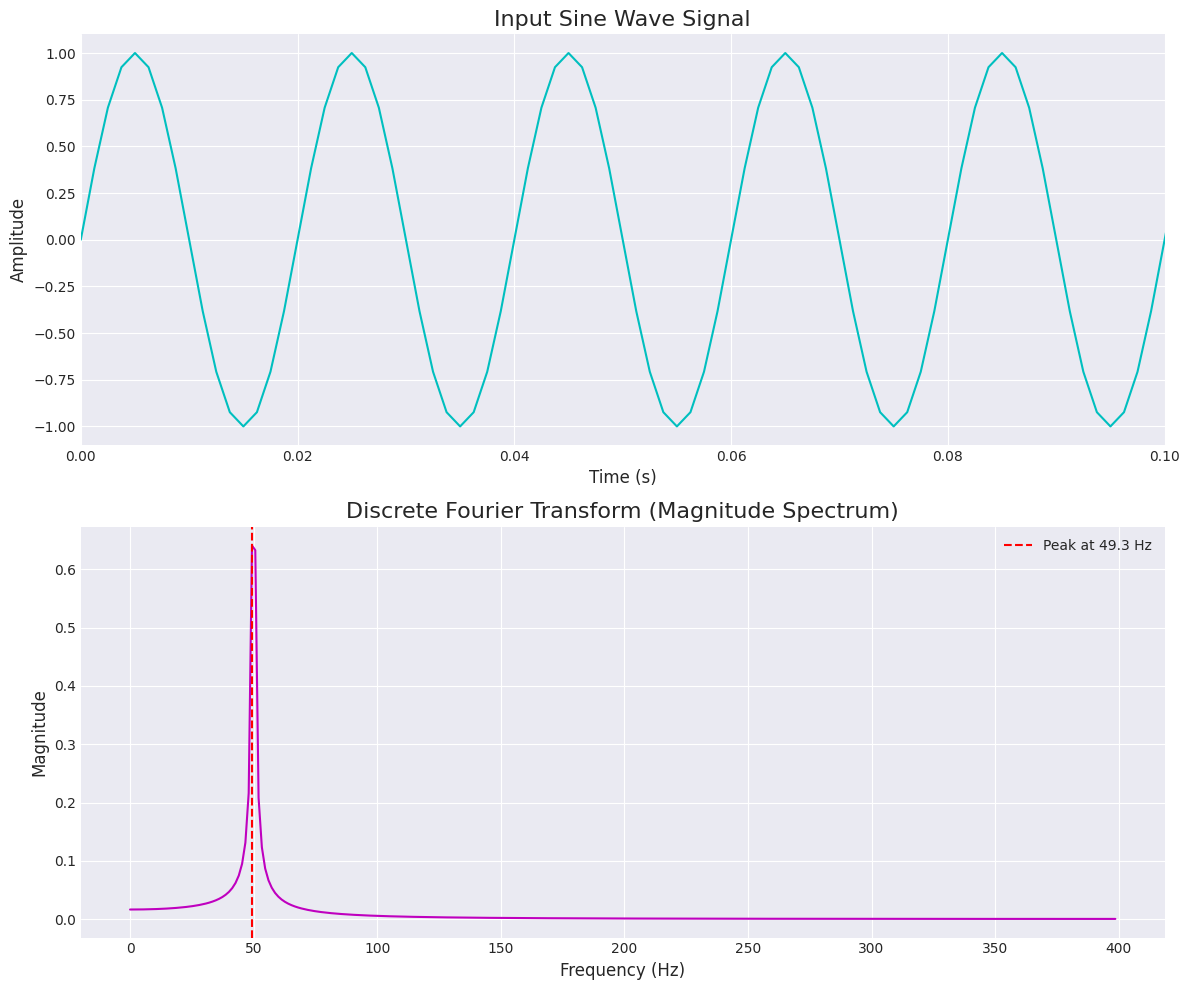

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

def naive_dft(x):
    """
    Computes the Discrete Fourier Transform (DFT) of a 1D signal.

    This is a "naïve" implementation that directly follows the DFT formula,
    which has a time complexity of O(N^2).

    Args:
        x (np.ndarray): The input signal, a 1D NumPy array.

    Returns:
        np.ndarray: The complex-valued DFT of the input signal.
    """
    N = len(x)
    # Create an empty array of complex numbers to store the DFT results
    X = np.zeros(N, dtype=np.complex128)

    # Iterate through each frequency bin (k)
    for k in range(N):
        # For each frequency bin, sum the contributions from all input samples (n)
        for n in range(N):
            # The core DFT formula: x[n] * e^(-2j * pi * k * n / N)
            angle = -2j * np.pi * k * n / N
            X[k] += x[n] * np.exp(angle)

    return X

# --- Main Script ---

# 1. Generate the Signal
# Parameters for the signal
N = 600                # Number of sample points
SAMPLE_RATE = 800.0    # Sampling rate in Hz
FREQUENCY = 50.0       # Frequency of the sine wave in Hz

# Calculate sample spacing
T = 1.0 / SAMPLE_RATE

# Create the time vector
# np.linspace generates evenly spaced numbers over a specified interval.
# We use endpoint=False because the interval is periodic.
t = np.linspace(0.0, N * T, N, endpoint=False)

# Create the sine wave signal
y = np.sin(FREQUENCY * 2.0 * np.pi * t)

# 2. Apply the DFT and Time the Execution

# Time the naïve DFT implementation
start_time_naive = time.time()
dft_result = naive_dft(y)
end_time_naive = time.time()
naive_duration = end_time_naive - start_time_naive

# Time NumPy's FFT implementation
start_time_fft = time.time()
fft_result = np.fft.fft(y)
end_time_fft = time.time()
fft_duration = end_time_fft - start_time_fft

# 3. Print Timings and Verification
print("--- DFT/FFT Performance Comparison ---")
print(f"Naïve DFT Execution Time: {naive_duration:.6f} seconds")
print(f"NumPy FFT Execution Time: {fft_duration:.6f} seconds")
# It's possible for the FFT to be so fast that the duration is 0.0, so we handle that case.
if fft_duration > 0:
    print(f"FFT is approximately {naive_duration / fft_duration:.2f} times faster.")
else:
    print("FFT was too fast to measure a significant duration difference.")

# Check if our implementation is close to NumPy's result
# np.allclose is used for comparing floating-point arrays.
print(f"\nOur DFT implementation is close to NumPy's FFT: {np.allclose(dft_result, fft_result)}")


# 4. Prepare for Plotting
# Generate the frequency axis for the plot.
# np.fft.fftfreq returns the DFT sample frequencies.
# We only need the first half of the frequencies (the positive ones) due to symmetry.
xf = np.fft.fftfreq(N, T)[:N//2]

# 5. Visualize the Results
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the original time-domain signal
ax1.plot(t, y, color='c')
ax1.set_title('Input Sine Wave Signal', fontsize=16)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_xlim(0, 0.1) # Show a few cycles of the sine wave
ax1.grid(True)

# Plot the frequency-domain signal (magnitude of the DFT)
# We normalize the magnitude by N and multiply by 2 to get the correct amplitude.
magnitude = 2.0/N * np.abs(dft_result[0:N//2])
ax2.plot(xf, magnitude, color='m')
ax2.set_title('Discrete Fourier Transform (Magnitude Spectrum)', fontsize=16)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Magnitude', fontsize=12)
ax2.grid(True)

# Add a vertical line to mark the peak frequency
peak_freq_index = np.argmax(magnitude)
peak_freq = xf[peak_freq_index]
ax2.axvline(peak_freq, color='r', linestyle='--', label=f'Peak at {peak_freq:.1f} Hz')
ax2.legend()


plt.tight_layout()
plt.show()

## Use the code given to compare the frequencies. Components obtained from the DFT with those originally used to construct the square wave. Do you notice any differences, and if so, why might they occur?
TODO

Prompt: modify the ’square_wave’, ’square_wave_fourier’ and ’naive_dft’ functions so 
that they are implemented using TensorFlow (TF) or PyTorch operations. For ’naive_dft’ in particular,
create a second version that explicitly runs on the GPU using TF/PyTorch tensor operations (rather
than their built-in FFT functions, which behave similarly to NumPy’s implementation)

In [ ]:
import numpy as np
import tensorflow as tf

# ----- TensorFlow square wave (uses global f0 like your original) -----
def square_wave(t):
    """
    TensorFlow implementation: returns a NumPy array.
    """
    t_tf = tf.convert_to_tensor(t, dtype=tf.float64)
    y_tf = tf.sign(tf.sin(2.0 * np.pi * f0 * t_tf))
    return y_tf.numpy()

# ----- TensorFlow Fourier series reconstruction of a square wave -----
def square_wave_fourier_tf(t, f0, N):
    """
    TensorFlow implementation: sums the first N odd harmonics.
    Returns a NumPy array.
    """
    # t: shape [T], n: shape [N] with odd integers 1,3,5,...
    t_tf = tf.convert_to_tensor(t, dtype=tf.float64)                    # [T]
    n_tf = 2 * tf.range(N, dtype=tf.float64) + 1.0                      # [N]

    # Broadcast to [T, N]: sin(2π f0 t n) / n
    s_tf = tf.sin(2.0 * np.pi * f0 * tf.expand_dims(t_tf, 1) * n_tf) / n_tf
    y_tf = (4.0 / np.pi) * tf.reduce_sum(s_tf, axis=1)                  # [T]
    return y_tf.numpy()

# ----- TensorFlow naïve DFT (O(N^2)) on CPU -----
def naive_dft_tf_cpu(x):
    """
    Naïve DFT via TensorFlow linear algebra on CPU.
    No use of tf.signal.fft; this mirrors the formula with a dense matrix.
    Returns a NumPy array of complex128.
    """
    x = np.asarray(x)
    N = x.shape[0]

    with tf.device("/CPU:0"):
        # Indices
        k = tf.range(N, dtype=tf.float64)                                # [N]
        n = tf.range(N, dtype=tf.float64)                                # [N]
        kn = tf.expand_dims(k, 1) * tf.expand_dims(n, 0)                # [N, N]

        # Exponential matrix E[k,n] = exp(-2j*pi*k*n/N)
        angle = -2j * np.pi * tf.cast(kn / N, tf.complex128)            # [N, N]
        E = tf.exp(angle)                                               # [N, N]

        x_tf = tf.convert_to_tensor(x, dtype=tf.complex128)             # [N]
        X_tf = tf.matmul(E, tf.expand_dims(x_tf, 1))                    # [N, 1]
        return tf.squeeze(X_tf, axis=1).numpy()                         # [N]

# ----- TensorFlow naïve DFT (O(N^2)) explicitly on GPU -----
def naive_dft_tf_gpu(x):
    """
    Naïve DFT via TensorFlow on GPU (no FFT). Falls back to CPU if no GPU is visible.
    Returns a NumPy array of complex128.
    """
    x = np.asarray(x)
    N = x.shape[0]

    device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
    with tf.device(device):
        k = tf.range(N, dtype=tf.float64)
        n = tf.range(N, dtype=tf.float64)
        kn = tf.expand_dims(k, 1) * tf.expand_dims(n, 0)

        angle = -2j * np.pi * tf.cast(kn / N, tf.complex128)
        E = tf.exp(angle)

        x_tf = tf.convert_to_tensor(x, dtype=tf.complex128)
        X_tf = tf.matmul(E, tf.expand_dims(x_tf, 1))
        return tf.squeeze(X_tf, axis=1).numpy()

2025-09-14 19:06:59.537658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Google Colab FFT and DFT

In [ ]:
# GPU Copy Paste for Google Colab (ONLY RUN ON REMOTE; NO GPU ON LOCAL COMPUTER)
import numpy as np
import tensorflow as tf
import torch

# ----- TensorFlow square wave (uses global f0 like your original) -----
def square_wave(t):
    """
    TensorFlow implementation: returns a NumPy array.
    """
    t_tf = tf.convert_to_tensor(t, dtype=tf.float64)
    y_tf = tf.sign(tf.sin(2.0 * np.pi * f0 * t_tf))
    return y_tf.numpy()

# ----- TensorFlow Fourier series reconstruction of a square wave -----
def square_wave_fourier_tf(t, f0, N):
    """
    TensorFlow implementation: sums the first N odd harmonics.
    Returns a NumPy array.
    """
    # t: shape [T], n: shape [N] with odd integers 1,3,5,...
    t_tf = tf.convert_to_tensor(t, dtype=tf.float64)                    # [T]
    n_tf = 2 * tf.range(N, dtype=tf.float64) + 1.0                      # [N]

    # Broadcast to [T, N]: sin(2π f0 t n) / n
    s_tf = tf.sin(2.0 * np.pi * f0 * tf.expand_dims(t_tf, 1) * n_tf) / n_tf
    y_tf = (4.0 / np.pi) * tf.reduce_sum(s_tf, axis=1)                  # [T]
    return y_tf.numpy()

# ----- TensorFlow naïve DFT (O(N^2)) on CPU -----
def naive_dft_tf_cpu(x):
    """
    Naïve DFT via TensorFlow linear algebra on CPU.
    No use of tf.signal.fft; this mirrors the formula with a dense matrix.
    Returns a NumPy array of complex128.
    """
    x = np.asarray(x)
    N = x.shape[0]

    with tf.device("/CPU:0"):
        # Indices
        k = tf.range(N, dtype=tf.float64)                                # [N]
        n = tf.range(N, dtype=tf.float64)                                # [N]
        kn = tf.expand_dims(k, 1) * tf.expand_dims(n, 0)                # [N, N]

        # Exponential matrix E[k,n] = exp(-2j*pi*k*n/N)
        angle = -2j * np.pi * tf.cast(kn / N, tf.complex128)            # [N, N]
        E = tf.exp(angle)                                               # [N, N]

        x_tf = tf.convert_to_tensor(x, dtype=tf.complex128)             # [N]
        X_tf = tf.matmul(E, tf.expand_dims(x_tf, 1))                    # [N, 1]
        return tf.squeeze(X_tf, axis=1).numpy()                         # [N]

# ----- TensorFlow naïve DFT (O(N^2)) explicitly on GPU -----
def naive_dft_tf_gpu(x):
    """
    Naïve DFT via TensorFlow on GPU (no FFT). Falls back to CPU if no GPU is visible.
    Returns a NumPy array of complex128.
    """
    x = np.asarray(x)
    N = x.shape[0]

    device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
    with tf.device(device):
        k = tf.range(N, dtype=tf.float64)
        n = tf.range(N, dtype=tf.float64)
        kn = tf.expand_dims(k, 1) * tf.expand_dims(n, 0)

        angle = -2j * np.pi * tf.cast(kn / N, tf.complex128)
        E = tf.exp(angle)

        x_tf = tf.convert_to_tensor(x, dtype=tf.complex128)
        X_tf = tf.matmul(E, tf.expand_dims(x_tf, 1))
        return tf.squeeze(X_tf, axis=1).numpy()

dft_result = naive_dft_tf_gpu(y)                 # GPU version (uses /GPU:0 if available)

print("First 10 DFT coefficients:")
print(dft_result[:10])

N = len(dft_result)
T = 1.0 / SAMPLE_RATE   # same T as before

# Frequency axis
xf = np.fft.fftfreq(N, T)[:N//2]

# Magnitude (normalised)
magnitude = 2.0/N * np.abs(dft_result[:N//2])

peak_idx = np.argmax(magnitude)
print(f"Peak frequency: {xf[peak_idx]:.2f} Hz, Magnitude: {magnitude[peak_idx]:.3f}")

plt.figure(figsize=(10,6))
plt.plot(xf, magnitude, color='m')
plt.title("DFT Magnitude Spectrum (GPU version)", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()


import time
import numpy as np

# --- helper function to time ---
def time_call(fn, *args, label="method"):
    t0 = time.perf_counter()
    _ = fn(*args)
    t1 = time.perf_counter()
    duration = t1 - t0
    print(f"{label} runtime: {duration:.6f} seconds")
    return duration

def fft_torch(x):
    # Ensure input is a torch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.from_numpy(np.asarray(x))
    return torch.fft.fft(x)

# signal setup (Testing Here)
N = 1024
t = np.linspace(0.0, 1.0, N, endpoint=False)
x = square_wave_fourier_tf(t, f0=1.0, N=50)  # construct square wave

# --- run timings ---
t_fft   = time_call(fft_torch, x, label="PyTorch FFT")
t_cpu   = time_call(naive_dft_tf_cpu, x, label="Naïve DFT (CPU)")
t_gpu   = time_call(naive_dft_tf_gpu, x, label="Naïve DFT (GPU)")



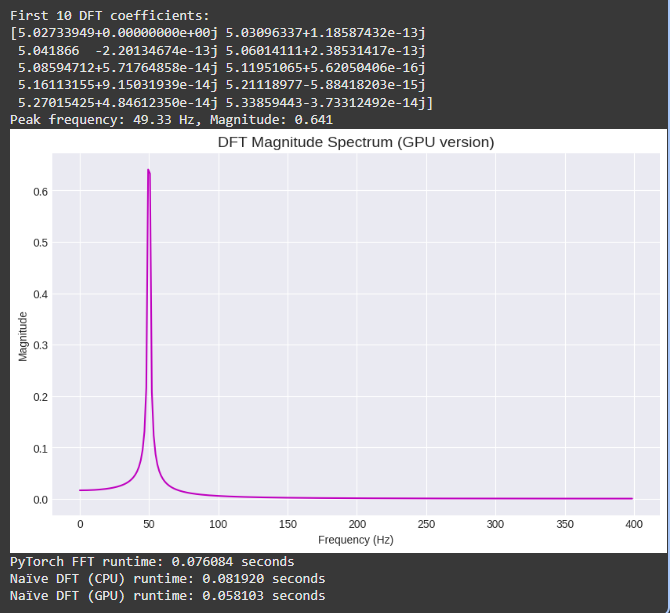

## Compare its computation time with the other two methods, note the times in order of fastest to slowest. Change the size of the data and note the change in timings of the three methods. Can you explain the order of the methods in terms of time, i.e., why is the fastest method the fastest you have observed?

TODO

## Change the size of the data and note the change in timings of the three methods.
TODO (more tests)

Task 2

### Eigenfaces: PCA of human faces using Numpy and the funnelled “Labeled Faces in the Wild” (LFW)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
(966, 150)
(322, 150)


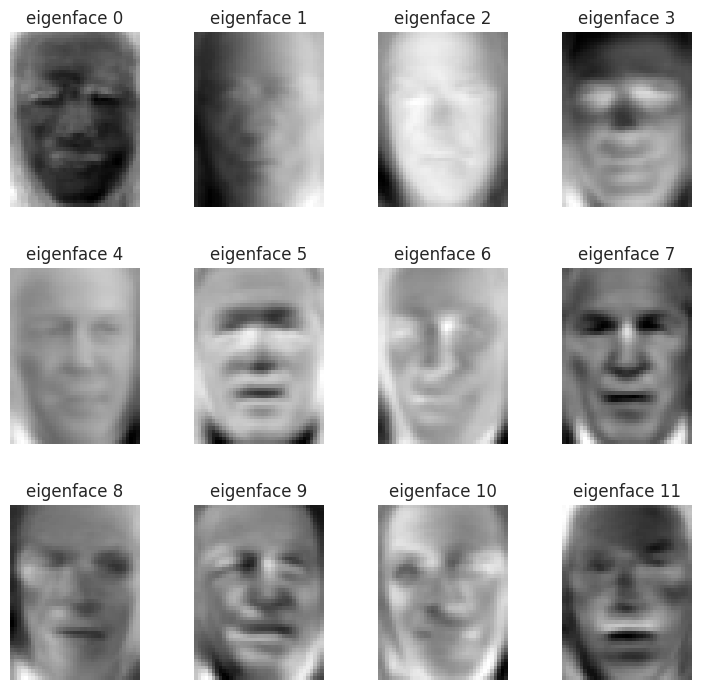

In [10]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  # (import kept for parity, not used below)
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# Load LFW (faces) dataset: downloads if not present and returns numpy arrays
# --------------------------------------------------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract key dataset parameters (useful for plotting and downstream modelling)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data                     # flattened images for ML models
n_features = X.shape[1]
y = lfw_people.target                   # integer labels
target_names = lfw_people.target_names  # string names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# --------------------------------------------------------------------
# Train/test split (stratified) to avoid information leakage
# --------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# --------------------------------------------------------------------
# PCA (Eigenfaces) via SVD on mean-centred training data
# Unsupervised feature extraction / dimensionality reduction
# --------------------------------------------------------------------
n_components = 150

# Centre data using training mean, then apply to test set
mean = np.mean(X_train, axis=0)
X_train = X_train - mean
X_test = X_test - mean

# SVD on centred training data; principal components are rows of V
U, S, V = np.linalg.svd(X_train, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

# Project train and test into the PCA subspace (“face space”)
X_transformed = np.dot(X_train, components.T)
print(X_transformed.shape)
X_test_transformed = np.dot(X_test, components.T)
print(X_test_transformed.shape)

# --------------------------------------------------------------------
# Visualise eigenfaces (principal axes reshaped as images)
# --------------------------------------------------------------------
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Plot a gallery of images with titles."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()


From Google Colab:

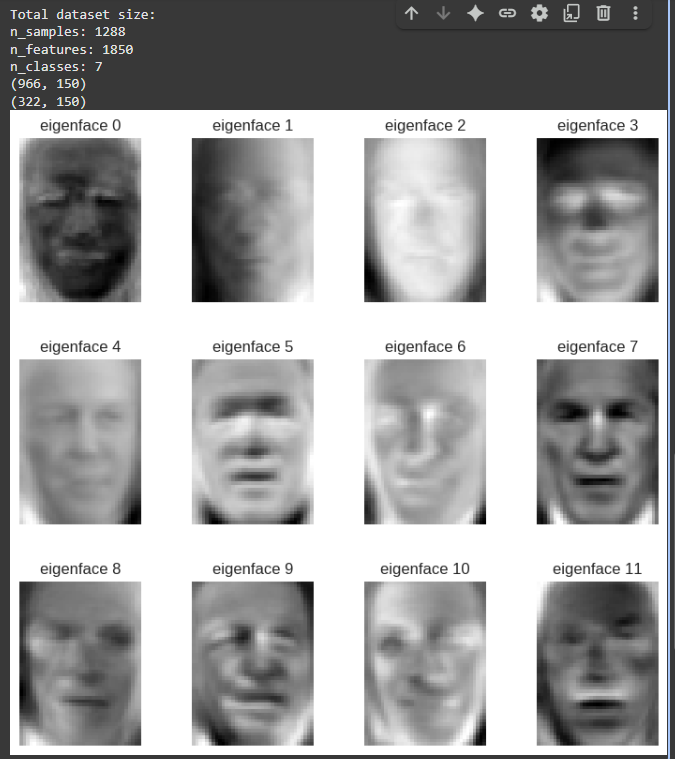


(966,)


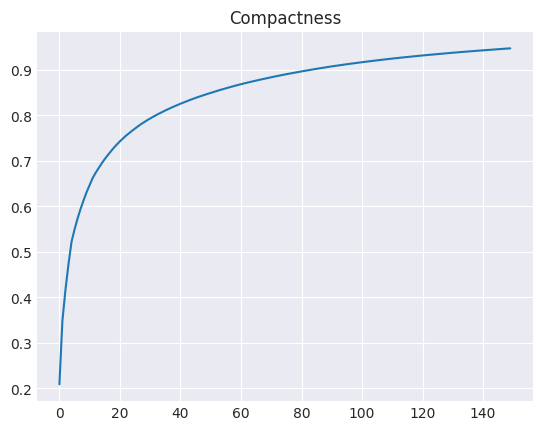

In [11]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)
eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions [3 3 6 3 3 3 3 1 3 3 3 3 3 3 3 3 4 3 3 4 1 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 3 3 3 1 1 1 3 3 4 3 3 3 3 3 1 2 1 3 3 3 6 1 3 4 3 6 3 4 1 3 6 6 3 3
 3 2 3 1 3 3 6 3 3 3 3 3 3 3 3 3 3 6 3 3 1 3 1 1 1 6 3 3 3 3 3 3 3 3 3 1 3
 1 3 3 3 3 1 4 1 3 1 3 3 1 3 4 5 3 1 3 6 6 6 3 3 4 3 3 6 6 3 3 3 1 3 3 3 3
 1 1 4 3 3 3 3 3 6 3 3 3 6 5 5 1 3 3 5 1 3 3 1 3 3 1 5 3 3 3 3 3 3 3 3 1 3
 3 3 3 3 2 4 3 2 3 6 3 3 3 3 3 3 3 3 3 5 1 4 2 6 3 1 5 3 3 3 3 3 1 3 3 3 3
 3 1 1 3 3 3 6 3 3 3 3 3 3 1 3 3 3 3 3 4 3 3 3 3 3 3 3 4 4 4 3 4 3 4 3 1 3
 3 3 3 3 1 3 6 6 1 6 1 1 3 3 3 6 3 3 3 3 3 1 1 3 3 3 0 3 3 3 4 3 3 5 3 3 1
 3 6 3 3 3 6 3 3 1 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 4 3]
Which Correct: [ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True False  True  True  True  True False  True False
 False  True False  True  True  True False  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True False  True
 False  T

Re-implement the above PCA algorithm of the Eigenfaces problem using
TF or PyTorch functions. (2 Marks)


In [14]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  # retained for parity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# Load LFW (faces) dataset
# --------------------------------------------------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Dataset parameters
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data                     # flattened images
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# --------------------------------------------------------------------
# Train/test split (stratified)
# --------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# --------------------------------------------------------------------
# PCA (Eigenfaces) via Torch SVD on mean-centred training data
# --------------------------------------------------------------------
n_components = 150

# Convert to torch tensors (float32 for efficiency/compatibility)
X_train_t = torch.from_numpy(X_train.astype(np.float32))
X_test_t  = torch.from_numpy(X_test.astype(np.float32))

# Centre using training mean; apply same mean to test
mean_t = X_train_t.mean(dim=0, keepdim=True)
X_train_c = X_train_t - mean_t
X_test_c  = X_test_t  - mean_t

# Torch SVD (thin SVD). Returns U, S, Vh with X = U @ diag(S) @ Vh
# On CPU for portability
U, S, Vh = torch.linalg.svd(X_train_c, full_matrices=False)

# Principal directions are rows of Vh (right singular vectors)
components_t = Vh[:n_components, :]                  # [n_components, n_features]
eigenfaces_t = components_t.reshape(n_components, h, w)

# Project train/test into PCA subspace (“face space”)
X_train_proj_t = X_train_c @ components_t.T          # [n_train, n_components]
X_test_proj_t  = X_test_c  @ components_t.T          # [n_test,  n_components]

print(tuple(X_train_proj_t.shape))
print(tuple(X_test_proj_t.shape))

# --------------------------------------------------------------------
# Visualise eigenfaces
# --------------------------------------------------------------------
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Plot a gallery of images with titles."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Move eigenfaces to numpy for plotting
eigenfaces = eigenfaces_t.cpu().numpy()
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

# --------------------------------------------------------------------
# Explained variance and compactness curve (Torch -> NumPy)
# --------------------------------------------------------------------
# Use the training sample count for variance normalisation
n_train = X_train.shape[0]
explained_variance = (S**2) / (n_train - 1)              # torch tensor
total_var = explained_variance.sum()
explained_variance_ratio = (explained_variance / total_var).cpu().numpy()
ratio_cumsum = np.cumsum(explained_variance_ratio)
print(ratio_cumsum.shape)

eigenvalueCount = np.arange(n_components)
plt.plot(eigenvalueCount, ratio_cumsum[:n_components])
plt.title('Compactness')
plt.show()

# --------------------------------------------------------------------
# Random Forest on PCA features (convert projections to NumPy)
# --------------------------------------------------------------------
X_transformed = X_train_proj_t.cpu().numpy()
X_test_transformed = X_test_proj_t.cpu().numpy()

estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train)
predictions = estimator.predict(X_test_transformed)

correct = predictions == y_test
total_test = len(X_test_transformed)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:", correct)
print("Total Correct:", np.sum(correct))
print("Accuracy:", np.sum(correct) / total_test)
print(classification_report(y_test, predictions, target_names=target_names))


ModuleNotFoundError: No module named 'torch'

Google Colab:

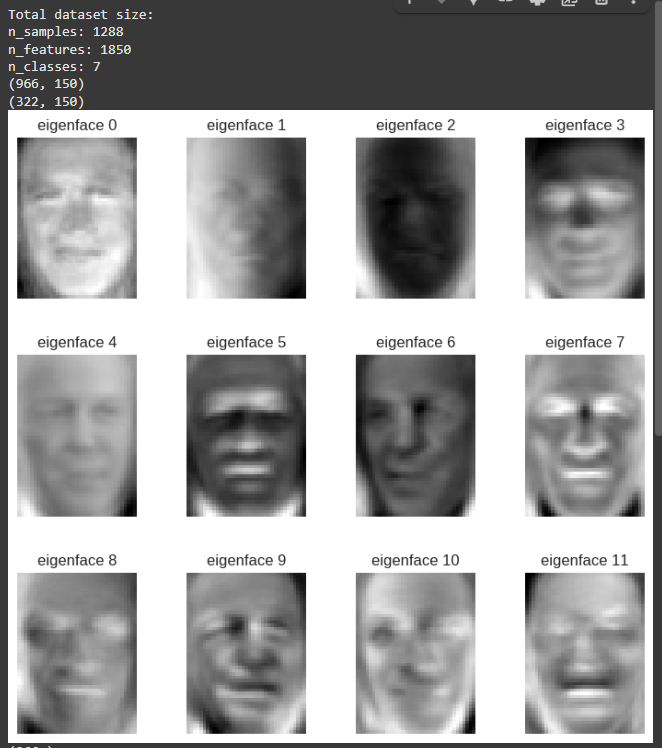
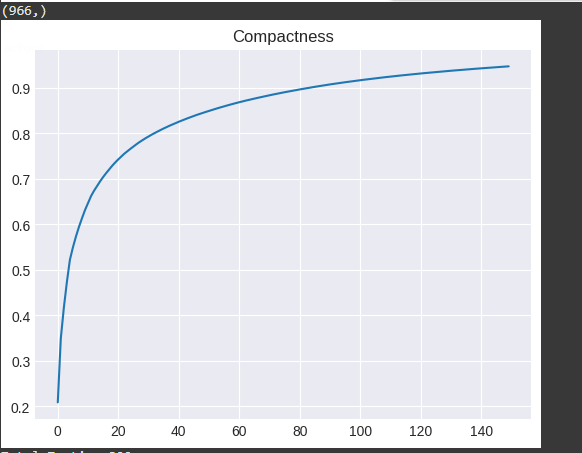
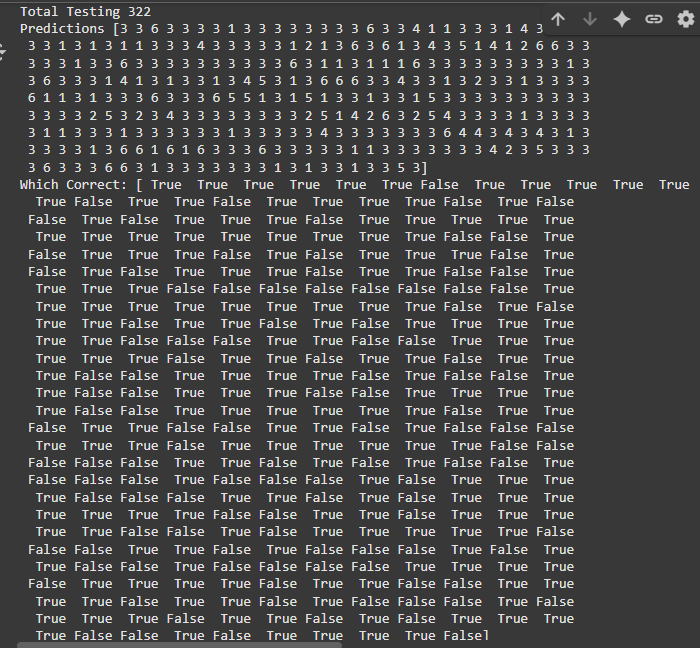
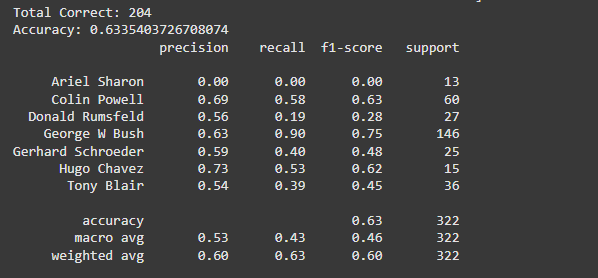

EXPLANATION + CONFIRMING GOOD CODE TODO

Task 3

CNN Classifier

X_min: 0.0 X_max: 1.0
X_train shape: (966, 50, 37, 1)


/home/thoemodachi/miniconda3/envs/ai/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 37, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 37, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,698,023 (14.11 MB)

 Trainable params: 3,698,023 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
13/13 - 8s - 619ms/step - accuracy: 0.3782 - loss: 1.7952 - val_accuracy: 0.4072 - val_loss: 1.7086
Epoch 2/12
13/13 - 5s - 360ms/step - accuracy: 0.4119 - loss: 1.6895 - val_accuracy: 0.4072 - val_loss: 1.6536
Epoch 3/12
13/13 - 5s - 368ms/step - accuracy: 0.4249 - loss: 1.6014 - val_accuracy: 0.5412 - val_loss: 1.5801
Epoch 4/12
13/13 - 5s - 404ms/step - accuracy: 0.4870 - loss: 1.4140 - val_accuracy: 0.5103 - val_loss: 1.3857
Epoch 5/12
13/13 - 6s - 439ms/step - accuracy: 0.5648 - loss: 1.2236 - val_accuracy: 0.6443 - val_loss: 1.1025
Epoch 6/12
13/13 - 5s - 381ms/step - accuracy: 0.6839 - loss: 0.9338 - val_accuracy: 0.6701 - val_loss: 0.9137
Epoch 7/12
13/13 - 5s - 412ms/step - accuracy: 0.7850 - loss: 0.6456 - val_accuracy: 0.7371 - val_loss: 0.7621
Epoch 8/12
13/13 - 6s - 468ms/step - accuracy: 0.8251 - loss: 0.5346 - val_accuracy: 0.7835 - val_loss: 0.6285
Epoch 9/12
13/13 - 5s - 397ms/step - accuracy: 0.8731 - loss: 0.4218 - val_accuracy: 0.8402 - val_loss: 0.5108
E

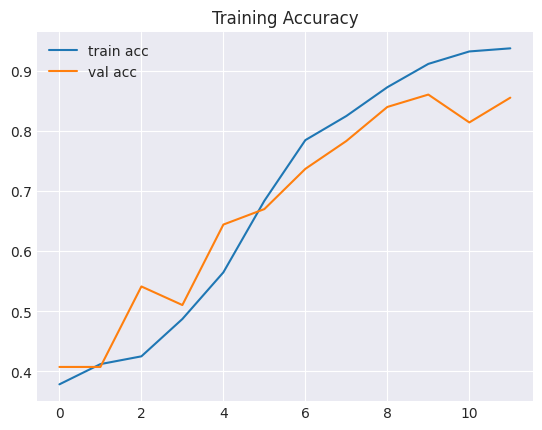

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models

# --------------------------------------------------------------------
# Load LFW dataset
# --------------------------------------------------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.images           # shape [n_samples, h, w]
Y = lfw_people.target
target_names = lfw_people.target_names
n_classes = len(target_names)

print("X_min:", X.min(), "X_max:", X.max())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

# Add channel dimension: (N, H, W, C=1) for TensorFlow
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)

# --------------------------------------------------------------------
# Define CNN (2 conv layers of 3×3, 32 filters each)
# --------------------------------------------------------------------
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# --------------------------------------------------------------------
# Train
# --------------------------------------------------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=12,
    batch_size=64,
    verbose=2
)

# --------------------------------------------------------------------
# Evaluate
# --------------------------------------------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=target_names))

# --------------------------------------------------------------------
# Optional: plot training history
# --------------------------------------------------------------------
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training Accuracy")
plt.show()


Google Colab:

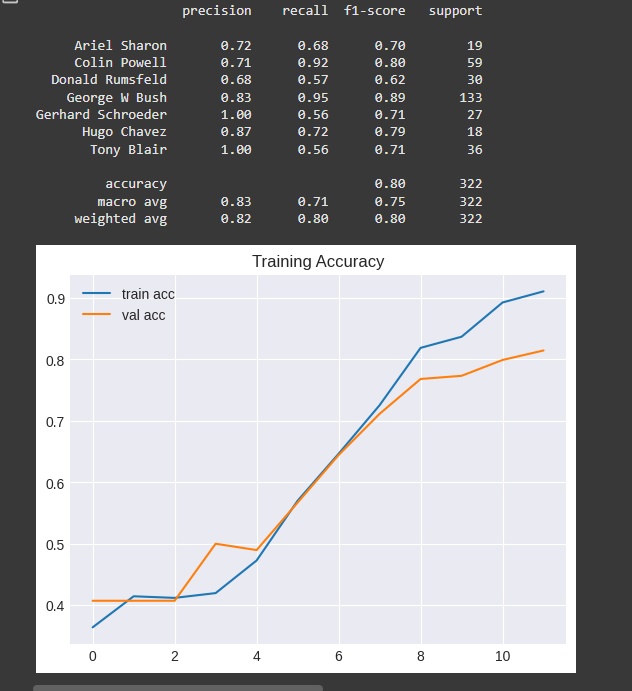

GIT Course:

https://learning.edge.edx.org/course/course-v1:UQx+GIT200x+2023_S1/home

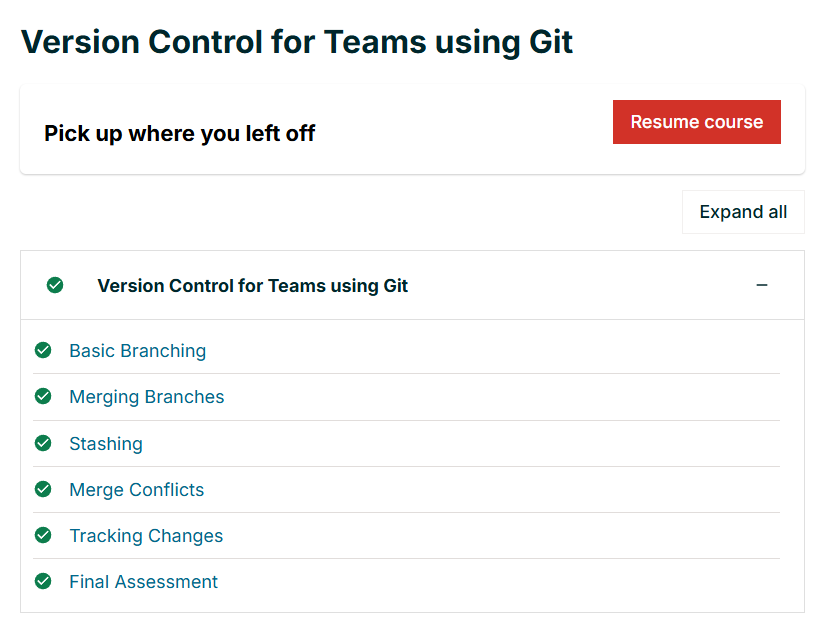

### ResNet18 & Mixed Precision

#### check fast_cifar10.py

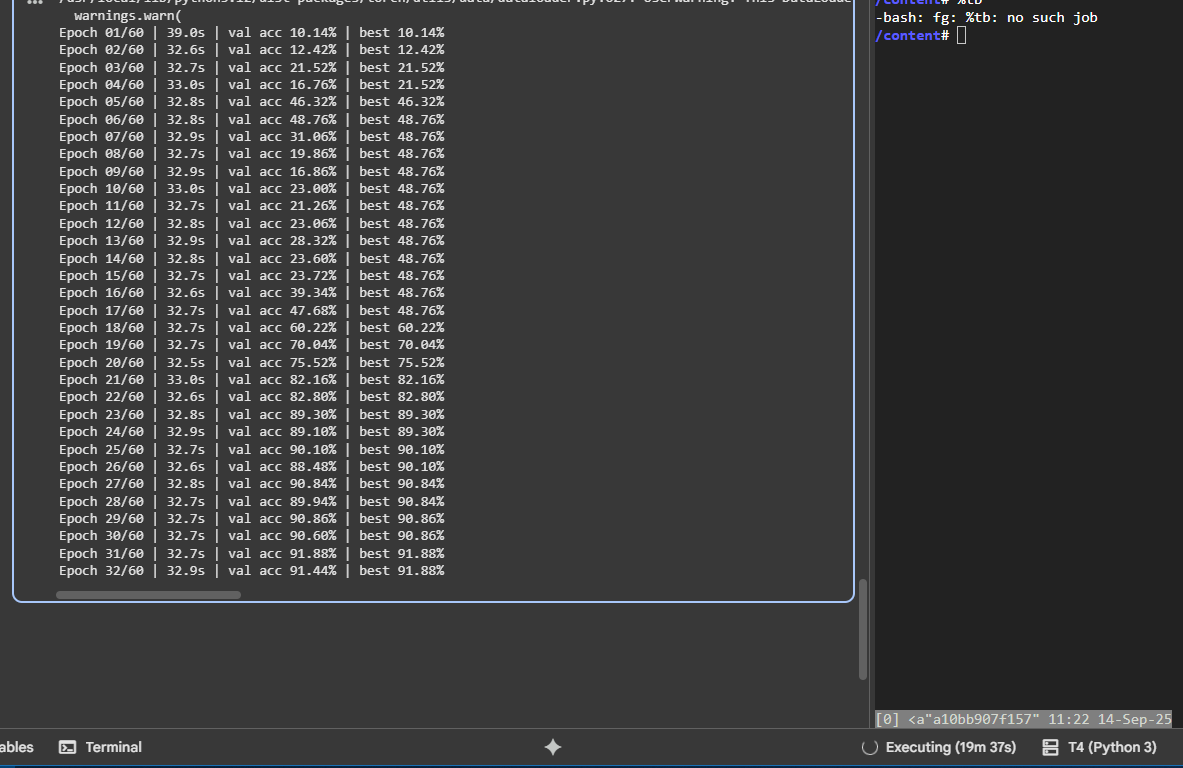

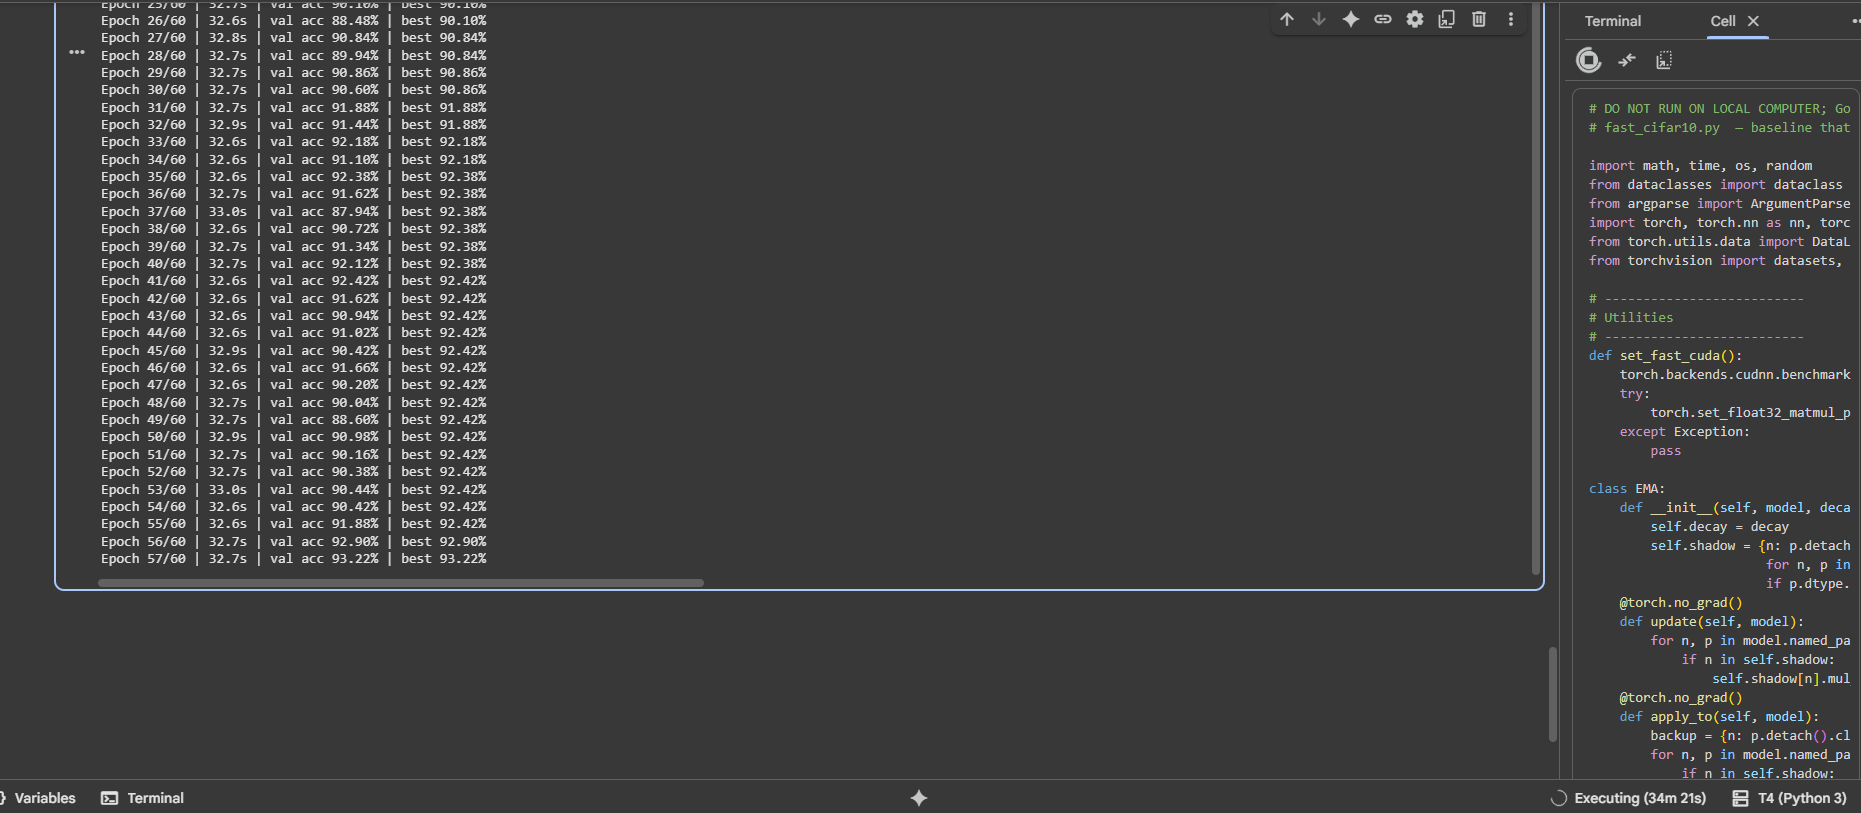

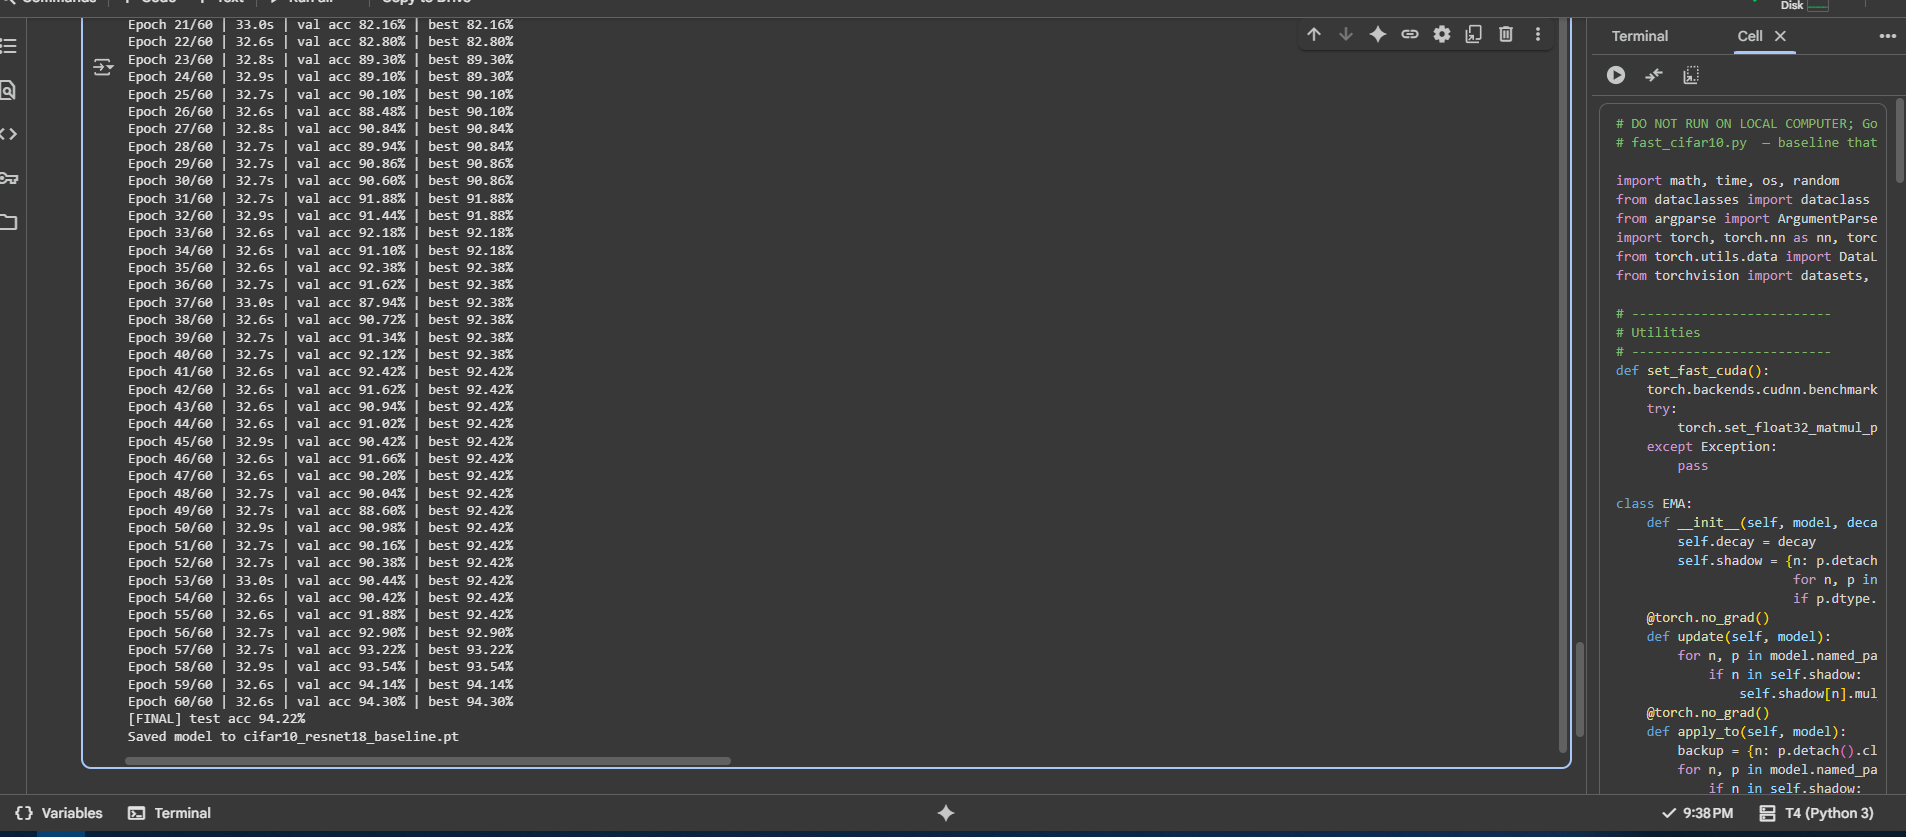

First attempt: 94.22% with 35min training time (60 epoch)

https://colab.research.google.com/drive/1OG2f2x8TVJaIpbbZYRU3-by2Dsy_97uY?usp=sharing